In [30]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.integrate import quad
import csv

In [2]:
ha_list = [('8133-12705', 0.130943), ('8256-12704', 0.12611), ('8616-3703', 0.135063),
             ('8720-12702', 0.134953), ('8721-3701', 0.118101)]
#('8137-9101', 0.118865),

ha_list_uncertain = ['8155-6103(?)', '8254-6103(?)', '8338-12705(?)', '8606-12704(?)']

ha_list2 = [('7815-6103', 0.135043), ('7991-12705', 0.113153), ('7992-9102', 0.119399), ('8132-6101', 0.129403),
             ('8132-12703', 0.116056), ('8133-12704', 0.134471), ('8137-3702', 0.131997),
             ('8143-6101', 0.126168), ('8244-12704', 0.115137), ('8318-6102', 0.12908), ('8329-6102', 0.142887),
             ('8439-3703', 0.138619), ('8448-3703', 0.138746), ('8464-6101', 0.125582), ('9049-1901', 0.131457)]

obj1_43214 = [('8135-1902', 0.117997)]

ha_list2_uncertain = ['8454-6102(?)', '8552-9102(?)', '8717-1902(?)']

In [3]:
def spectrum_gen(flux, ivar):    
    n = len(flux)
    sumflux = np.zeros(4563)

    for i in range(n):
        for j in range(n):
            flux_ = flux[i,j] * ~do_not_use[i,j]
            flux_filtered = sigma_gen_compare(ivar[i,j], flux_)
            sumflux = np.add(sumflux, flux_)
    return sumflux

In [16]:
def sigma_gen_compare(ivar, flux_masked):
    
    # change ivar array to sigma array 
    
    sigma = np.sqrt(np.abs(np.divide(1, ivar, where = ivar != 0)))
#     print(sigma)
    
    is_less_than_3sigma = flux_masked < 3 * sigma # compare the sigma array 
#     print(flux_masked)
#     print(is_less_than_3sigma)
        
    flux_masked_filtered = flux_masked * ~is_less_than_3sigma # multiply the truth value
    
    return flux_masked_filtered

In [17]:
def gaussian(x, amp, mean, sigma, base):
    return (amp * np.exp(-(x-mean)**2 / (2*sigma**2))) + base

In [18]:
def area_finder(x, y):
#     print('x',x)
#     print('y',y)
    dlmd = (x[-1] - x[0])/len(x)
#     print(dlmd)
        
    area = (1/2)*(dlmd)*(y[0] + y[-1] + np.sum(2*(y[1:-1])))
#     print('area', area)

    subtract = y[0] * (x[-1] - x[0])

    subtracted_area = area - subtract
#     print(subtracted_area)
    
    return subtracted_area

6563 6548 6583

In [40]:
header = ['mangaid', 'plateifu', 'nsa_z', 'flux']
with open('ha_list.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    
    writer.writerow(header)
    
    for plateifu in ha_list:
    #     print(plateifu)
        data = fits.open(f'/Volumes/WD_External/MaNGA_Sample/manga-{plateifu[0]}-LOGCUBE.fits.gz')
        mangaid = data[0].header['MANGAID']

        flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

        ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

        mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))

        do_not_use = (mask & 2**10) != 0 

        wave = data['WAVE'].data

        sumflux = spectrum_gen(flux, ivar)

        peak_ha = 6563 * (1 + plateifu[1])
        peak_6548 = 6548 * (1 + plateifu[1])
        peak_6583 = 6583 *(1 + plateifu[1])
    #     print(peak) 
        bound_ha = np.where(np.logical_and(wave > peak_ha-10, wave < peak_ha+15))
        bound_6548 = np.where(np.logical_and(wave > peak_6548-10, wave < peak_6548+10))
        bound_6583 = np.where(np.logical_and(wave > peak_6583-10, wave < peak_6583+18))

    #     print('bound', bound_6548, bound_6583)

        lb_ha = bound_ha[0][0]
        ub_ha = bound_ha[0][-1]

        lb_6548 = bound_6548[0][0]
        ub_6548 = bound_6548[0][-1] 

        lb_6583 = bound_6583[0][0]
        ub_6583 = bound_6583[0][-1] 

    #     print(lb_6548, ub_6548, lb_ha, ub_ha, lb_6583, ub_6583)
    #     print(wave[lb_6548], wave[ub_6548], wave[lb_ha], wave[ub_ha], wave[lb_6583], wave[ub_6583])

        sumflux_slice_ha = sumflux[lb_ha : ub_ha]
        sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
        sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]

    #     sumflux_slice = sumflux[lb_6548 : ub_6583]

    #     print('sumflux_slice',sumflux_slice)

        wave_slice_ha = wave[lb_ha : ub_ha]
        wave_slice_6548 = wave[lb_6548 : ub_6548]
        wave_slice_6583 = wave[lb_6583 : ub_6583]

    #     wave_slice = wave[lb_6548 : ub_6583]

    #     print('wave_slice', wave_slice)

        amp_ha = max(sumflux_slice_ha)
        mean_ha = peak_ha
        sigma_ha = np.std(wave_slice_ha)
        base_ha = min(sumflux_slice_ha)

        amp_6548 = max(sumflux_slice_6548)
        mean_6548 = peak_6548
        sigma_6548 = np.std(wave_slice_6548)
        base_6548 = min(sumflux_slice_6548)

        amp_6583 = max(sumflux_slice_6583)
        mean_6583 = peak_6583
        sigma_6583 = np.std(wave_slice_6583)
        base_6583 = min(sumflux_slice_6583)

    #     base = min(sumflux_slice)

    #     p0_ = [amp_ha, amp_6548, amp_6583,
    #            mean_ha, mean_6548, mean_6583,
    #            sigma_ha, sigma_6548, sigma_6583,
    #            base]

        p0_ha = [amp_ha, mean_ha, sigma_ha, base_ha]
        p0_6548 = [amp_6548, mean_6548, sigma_6548, base_6548]
        p0_6583 = [amp_6583, mean_6583, sigma_6583, base_6583]

        popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
        popt_6548, pcov_6548 = curve_fit(gaussian, wave_slice_6548, sumflux_slice_6548, p0 = p0_6548)
        popt_6583, pcov_6583 = curve_fit(gaussian, wave_slice_6583, sumflux_slice_6583, p0 = p0_6583)

    #     print(popt_ha, [*popt_ha])

        area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (popt_ha[0],
                                                                           popt_ha[1],
                                                                           popt_ha[2],
                                                                           popt_ha[3]))
        print('Integrated area =', area[0])

        continuum = (wave_slice_ha[-1] - wave_slice_ha[0]) * popt_ha[-1]

        subtracted_area = area[0] - continuum

        print('Subtracted area =', subtracted_area)

        trapezium_area = area_finder(wave_slice_ha, sumflux_slice_ha)

        print('Trapezium area =', trapezium_area)

        writer.writerow([mangaid, plateifu[0], plateifu[1], subtracted_area])

    #     print('popt', popt)
    #     print('pcov', pcov)

    # #     print('amp', amp)
    # #     print('sigma', sigma)
    # #     print('base', base)

    #     popt, pcov = curve_fit(gaussian, wave_slice, sumflux_slice, p0 = [amp, mean, sigma, base])
    #     print('popt', popt)
    #     print('pcov', pcov)

    #     plt.plot(wave_slice, gaussian(wave_slice, *popt))
    #     plt.show()

    #     print(sumflux, len(sumflux))

#         plt.figure(figsize = (15,8))
#         plt.grid()
#         plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
#         plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
#         plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
#         plt.legend()
#     #     plt.axvline(wave[lb], color = 'deeppink')
#     #     plt.axvline(wave[ub], color = 'deeppink')
#     #     plt.xlim(6300,6700)
#         plt.xlim(7300, 7500)
#     #     plt.xlim(wave[lb]-10, wave[ub]+10)
#         plt.ylim(0,400)
#         plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
#         plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
#         plt.title(f'MaNGA ID = {mangaid}')

#         plt.axvline(wave_slice_ha[0])
#         plt.axvline(wave_slice_ha[-1])
#         print(wave_slice_ha[-1] - wave_slice_ha[0])
#         print(popt_ha)

#         plt.plot(wave, sumflux)

#         plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)
#         plt.plot(wave_slice_6548, gaussian(wave_slice_6548, *popt_6548), linewidth = 2, color = 'red')
#         plt.plot(wave_slice_6583, gaussian(wave_slice_6583, *popt_6583), linewidth = 2, color = 'red')

#         plt.show()

Integrated area = 2934.173124781389
Subtracted area = 934.7125709699526
Trapezium area = 673.9090567272469
Integrated area = 4182.1321665253845
Subtracted area = 504.76094256983333
Trapezium area = 233.19437242059075
Integrated area = 3221.539359074743
Subtracted area = 5559.9441759127685
Trapezium area = 999.0361006732921
Integrated area = 2450.91536039078
Subtracted area = 526.323773012012
Trapezium area = 69.8035670835925
Integrated area = 2932.0771526198578
Subtracted area = 957.464723715939
Trapezium area = 585.6303968297802


In [39]:
header = ['mangaid', 'plateifu', 'nsa_z', 'flux']
with open('ha_list2.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    
    writer.writerow(header)
    for plateifu in ha_list2:
    #     print(plateifu)
        data = fits.open(f'/Volumes/WD_External/MaNGA_Sample_with_[OIII]/manga-{plateifu[0]}-LOGCUBE.fits.gz')
        mangaid = data[0].header['MANGAID']

        flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

        ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

        mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))

        do_not_use = (mask & 2**10) != 0 

        wave = data['WAVE'].data

        sumflux = spectrum_gen(flux, ivar)

        peak_ha = 6563 * (1 + plateifu[1])
        peak_6548 = 6548 * (1 + plateifu[1])
        peak_6583 = 6583 *(1 + plateifu[1])
    #     print(peak) 
        bound_ha = np.where(np.logical_and(wave > peak_ha-10, wave < peak_ha+15))
        bound_6548 = np.where(np.logical_and(wave > peak_6548-10, wave < peak_6548+10))
        bound_6583 = np.where(np.logical_and(wave > peak_6583-10, wave < peak_6583+15))

    #     print('bound', bound_6548, bound_6583)

        lb_ha = bound_ha[0][0]
        ub_ha = bound_ha[0][-1]

        lb_6548 = bound_6548[0][0]
        ub_6548 = bound_6548[0][-1] 

        lb_6583 = bound_6583[0][0]
        ub_6583 = bound_6583[0][-1] 

    #     print(lb_6548, ub_6548, lb_ha, ub_ha, lb_6583, ub_6583)
    #     print(wave[lb_6548], wave[ub_6548], wave[lb_ha], wave[ub_ha], wave[lb_6583], wave[ub_6583])

        sumflux_slice_ha = sumflux[lb_ha : ub_ha]
        sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
        sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]

    #     sumflux_slice = sumflux[lb_6548 : ub_6583]

    #     print('sumflux_slice',sumflux_slice)

        wave_slice_ha = wave[lb_ha : ub_ha]
        wave_slice_6548 = wave[lb_6548 : ub_6548]
        wave_slice_6583 = wave[lb_6583 : ub_6583]

    #     wave_slice = wave[lb_6548 : ub_6583]

    #     print('wave_slice', wave_slice)

        amp_ha = max(sumflux_slice_ha)
        mean_ha = peak_ha
        sigma_ha = np.std(wave_slice_ha)
        base_ha = min(sumflux_slice_ha)

        amp_6548 = max(sumflux_slice_6548)
        mean_6548 = peak_6548
        sigma_6548 = np.std(wave_slice_6548)
        base_6548 = min(sumflux_slice_6548)

        amp_6583 = max(sumflux_slice_6583)
        mean_6583 = peak_6583
        sigma_6583 = np.std(wave_slice_6583)
        base_6583 = min(sumflux_slice_6583)

    #     base = min(sumflux_slice)

    #     p0_ = [amp_ha, amp_6548, amp_6583,
    #            mean_ha, mean_6548, mean_6583,
    #            sigma_ha, sigma_6548, sigma_6583,
    #            base]

        p0_ha = [amp_ha, mean_ha, sigma_ha, base_ha]
        p0_6548 = [amp_6548, mean_6548, sigma_6548, base_6548]
        p0_6583 = [amp_6583, mean_6583, sigma_6583, base_6583]

        popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
        popt_6548, pcov_6548 = curve_fit(gaussian, wave_slice_6548, sumflux_slice_6548, p0 = p0_6548)
        popt_6583, pcov_6583 = curve_fit(gaussian, wave_slice_6583, sumflux_slice_6583, p0 = p0_6583)

        area = quad(gaussian, wave_slice_ha[0], wave_slice_ha[-1], args = (popt_ha[0],
                                                                           popt_ha[1],
                                                                           popt_ha[2],
                                                                           popt_ha[3]))
        print('Integrated area =', area[0])

        continuum = (wave_slice_ha[-1] - wave_slice_ha[0]) * popt_ha[-1]

        subtracted_area = area[0] - continuum

        print('Subtracted area =', subtracted_area)

        trapezium_area = area_finder(wave_slice_ha, sumflux_slice_ha)

        print('Trapezium area =', trapezium_area)
        
        writer.writerow([mangaid, plateifu[0], plateifu[1], subtracted_area])

    #     print('popt', popt)
    #     print('pcov', pcov)

    # #     print('amp', amp)
    # #     print('sigma', sigma)
    # #     print('base', base)

    #     popt, pcov = curve_fit(gaussian, wave_slice, sumflux_slice, p0 = [amp, mean, sigma, base])
    # #     print('popt', popt)
    # #     print('pcov', pcov)

    # #     plt.plot(wave_slice, gaussian(wave_slice, *popt))
    # #     plt.show()

    # #     print(sumflux, len(sumflux))

#         plt.figure(figsize = (15,8))
#         plt.grid()
#         plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
#         plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
#         plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
#         plt.legend()
#     #     plt.axvline(wave[lb], color = 'deeppink')
#     #     plt.axvline(wave[ub], color = 'deeppink')
#     #     plt.xlim(6300,6700)
#         plt.xlim(7250, 7550)
#     #     plt.xlim(wave[lb]-10, wave[ub]+10)
#         plt.ylim(0,400)
#         plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
#         plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
#         plt.title(f'MaNGA ID = {mangaid}')

#         plt.axvline(wave_slice_ha[0])
#         plt.axvline(wave_slice_ha[-1])
#         print(wave_slice_ha[-1] - wave_slice_ha[0])
#         print(popt_ha)


#         plt.plot(wave, sumflux)

#         plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)
#         plt.plot(wave_slice_6548, gaussian(wave_slice_6548, *popt_6548), linewidth = 2, color = 'red')
#         plt.plot(wave_slice_6583, gaussian(wave_slice_6583, *popt_6583), linewidth = 2, color = 'red')

#         plt.show()

Integrated area = 3217.4508459182116
Subtracted area = 1823.2673255989193
Trapezium area = 1468.1439527924163
Integrated area = 2960.878527352014
Subtracted area = 2954833.1249252465
Trapezium area = 211.37681382828896
Integrated area = 2867.4169467996758
Subtracted area = 2028.8921528083852
Trapezium area = 235.1777967862531


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Integrated area = 3344.047139381515
Subtracted area = 3476035.7644638587
Trapezium area = 522.8032877833161
Integrated area = 4567.48592920636
Subtracted area = 2390.393860940304
Trapezium area = 1823.5524125669867
Integrated area = 2470.5230191937394
Subtracted area = 329.4039670328657
Trapezium area = -131.9266523153733
Integrated area = 2687.42639832453
Subtracted area = 595.560345001054
Trapezium area = 159.66310145287343
Integrated area = 4186.3699618284145
Subtracted area = 699.4483455624577
Trapezium area = 272.5943840823311
Integrated area = 5111.251386364964
Subtracted area = 12783872.600699369
Trapezium area = 1604.228001020711
Integrated area = 4710.2071460271245
Subtracted area = 980.6638303755694
Trapezium area = 529.6603140994353
Integrated area = 2724.410065958242
Subtracted area = 922.2661678218624
Trapezium area = 495.4493617381663


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """


Integrated area = 3072.677233733771
Subtracted area = 1376.077286199315
Trapezium area = 926.770073075719
Integrated area = 3968.4153459653253
Subtracted area = 1487.237260436692
Trapezium area = 1198.6611245765816
Integrated area = 5129.335014787637
Subtracted area = 2791.5556698278324
Trapezium area = 1764.7641592285713
Integrated area = 3526.716188895774
Subtracted area = 1398.8830107367094
Trapezium area = 985.2555344788402


In [12]:
def gaussian_1_43214(x, amp, mean, sigma):
    return (amp * np.exp(-(x-mean)**2 / (2*sigma**2)))

In [13]:
def three_gaussian(x, 
                   a_ha, a_6548, a_6583,
                   m_ha, m_6548, m_6583,
                   s_ha, s_6548, s_6583,
                   base):
    gaussian_ha = gaussian_1_43214(x, amp_ha, mean_ha, sigma_ha)
    gaussian_6548 = gaussian_1_43214(x, amp_6548, mean_6548, sigma_6548)
    gaussian_6583 = gaussian_1_43214(x, amp_6583, mean_6583, sigma_6583)
    return gaussian_ha + gaussian_6548 + gaussian_6583 + base

3051 3062 3061 3072 3074 3085


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


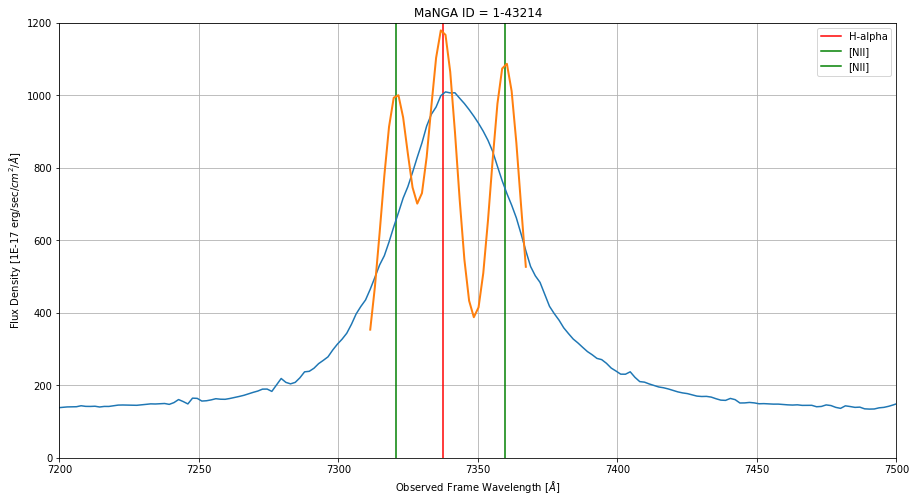

In [14]:
for plateifu in obj1_43214:
#     print(plateifu)
    data = fits.open(f'/Volumes/WD_External/MaNGA_Sample_with_[OIII]/manga-{plateifu[0]}-LOGCUBE.fits.gz')
    mangaid = data[0].header['MANGAID']
    
    flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

    ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

    mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))
    
    do_not_use = (mask & 2**10) != 0 
    
    wave = data['WAVE'].data
    
    sumflux = spectrum_gen(flux, ivar)
    
    peak_ha = 6563*(1+plateifu[1])
    peak_6548 = 6548*(1+plateifu[1])
    peak_6583 = 6583*(1+plateifu[1])

    bound_ha = np.where(np.logical_and(wave > (peak_ha-10), wave < (peak_ha+10)))
    bound_6548 = np.where(np.logical_and(wave > (peak_6548-10), wave < (peak_6548+10)))
    bound_6583 = np.where(np.logical_and(wave > (peak_6583-10), wave < (peak_6583+10)))
        
    lb_ha = bound_ha[0][0]
    ub_ha = bound_ha[0][-1]
    
    lb_6548 = bound_6548[0][0]
    ub_6548 = bound_6548[0][-1] 
    
    lb_6583 = bound_6583[0][0]
    ub_6583 = bound_6583[0][-1] 
    
    print(lb_6548, ub_6548, lb_ha, ub_ha, lb_6583, ub_6583)
    
    sumflux_slice_ha = sumflux[lb_ha : ub_ha]
    sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
    sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]
    
    sumflux_slice = sumflux[lb_6548 : ub_6583]
    
    wave_slice_ha = wave[lb_ha : ub_ha]
    wave_slice_6548 = wave[lb_6548 : ub_6548]
    wave_slice_6583 = wave[lb_6583 : ub_6583]
    
    wave_slice = wave[lb_6548 : ub_6583]
        
    amp_ha = max(sumflux_slice_ha)
    mean_ha = peak_ha
    sigma_ha = np.std(wave_slice_ha)
    
    amp_6548 = max(sumflux_slice_6548)
    mean_6548 = peak_6548
    sigma_6548 = np.std(wave_slice_6548)
    
    amp_6583 = max(sumflux_slice_6583)
    mean_6583 = peak_6583
    sigma_6583 = np.std(wave_slice_6583)

    base = min(sumflux_slice)
    
    p0_ = [amp_ha, amp_6548, amp_6583,
           mean_ha, mean_6548, mean_6583,
           sigma_ha, sigma_6548, sigma_6583,
           base]
    
    popt, pcov = curve_fit(three_gaussian, wave_slice, sumflux_slice, p0 = p0_)

    plt.figure(figsize = (15,8))
    plt.grid()
    plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
    plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
    plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
    plt.legend()

    plt.xlim(7200, 7500)
    plt.ylim(0,1200)
    
    plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
    plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.title(f'MaNGA ID = {mangaid}')
    
    plt.plot(wave, sumflux)
    plt.plot(wave_slice, three_gaussian(wave_slice, *popt), linewidth = 2)
    
    plt.show()

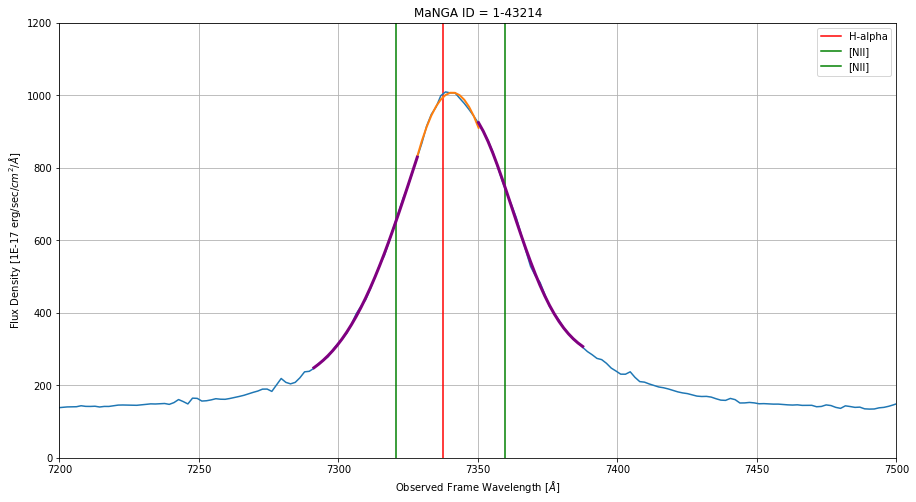

In [15]:
for plateifu in obj1_43214:
#     print(plateifu)
    data = fits.open(f'/Volumes/WD_External/MaNGA_Sample_with_[OIII]/manga-{plateifu[0]}-LOGCUBE.fits.gz')
    mangaid = data[0].header['MANGAID']
    
    flux = np.transpose(data['FLUX'].data, axes = (2, 1, 0))

    ivar = np.transpose(data['IVAR'].data, axes = (2, 1, 0))

    mask = np.transpose(data['MASK'].data, axes = (2, 1, 0))
    
    do_not_use = (mask & 2**10) != 0 
    
    wave = data['WAVE'].data
    
    sumflux = spectrum_gen(flux, ivar)
    
    peak_ha = 6563 * (1 + plateifu[1])
    peak_6548 = 6548 * (1 + plateifu[1])
    peak_6583 = 6583 *(1 + plateifu[1])

    bound_ha = np.where(np.logical_and(wave > peak_ha-10, wave < peak_ha+15))
    bound_6548 = np.where(np.logical_and(wave > peak_6548-30, wave < peak_6548+10))
    bound_6583 = np.where(np.logical_and(wave > peak_6583-10, wave < peak_6583+30))
        
    lb_ha = bound_ha[0][0]
    ub_ha = bound_ha[0][-1]
    
    lb_6548 = bound_6548[0][0]
    ub_6548 = bound_6548[0][-1] 
    
    lb_6583 = bound_6583[0][0]
    ub_6583 = bound_6583[0][-1] 
    
    sumflux_slice_ha = sumflux[lb_ha : ub_ha]
    sumflux_slice_6548 = sumflux[lb_6548 : ub_6548]
    sumflux_slice_6583 = sumflux[lb_6583 : ub_6583]

    wave_slice_ha = wave[lb_ha : ub_ha]
    wave_slice_6548 = wave[lb_6548 : ub_6548]
    wave_slice_6583 = wave[lb_6583 : ub_6583]
    
    amp_ha = max(sumflux_slice_ha)
    mean_ha = peak_ha
    sigma_ha = np.std(wave_slice_ha)
    base_ha = min(sumflux_slice_ha)
    
    amp_6548 = max(sumflux_slice_6548)
    mean_6548 = peak_6548
    sigma_6548 = np.std(wave_slice_6548)
    base_6548 = min(sumflux_slice_6548)
    
    amp_6583 = max(sumflux_slice_6583)
    mean_6583 = peak_6583
    sigma_6583 = np.std(wave_slice_6583)
    base_6583 = min(sumflux_slice_6583)

    p0_ha = [amp_ha, mean_ha, sigma_ha, base_ha]
    p0_6548 = [amp_6548, mean_6548, sigma_6548, base_6548]
    p0_6583 = [amp_6583, mean_6583, sigma_6583, base_6583]
    
    popt_ha, pcov_ha = curve_fit(gaussian, wave_slice_ha, sumflux_slice_ha, p0 = p0_ha)
    popt_6548, pcov_6548 = curve_fit(gaussian, wave_slice_6548, sumflux_slice_6548, p0 = p0_6548)
    popt_6583, pcov_6583 = curve_fit(gaussian, wave_slice_6583, sumflux_slice_6583, p0 = p0_6583)
    
    plt.figure(figsize = (15,8))
    plt.grid()
    plt.axvline(6563*(1+plateifu[1]), color = 'red', label = 'H-alpha')
    plt.axvline(6548*(1+plateifu[1]), color = 'green', label = '[NII]')
    plt.axvline(6583*(1+plateifu[1]), color = 'green', label = '[NII]')
    plt.legend()

    plt.xlim(7200, 7500)
    plt.ylim(0,1200)
    
    plt.xlabel('Observed Frame Wavelength ' + r'[$\AA$]')
    plt.ylabel('Flux Density [1E-17 erg/sec/'+r'$cm^2$/'+r'$\AA$]')
    plt.title(f'MaNGA ID = {mangaid}')
    
    plt.plot(wave, sumflux)
    
    plt.plot(wave_slice_ha, gaussian(wave_slice_ha, *popt_ha), linewidth = 2)
    plt.plot(wave_slice_6548, gaussian(wave_slice_6548, *popt_6548), linewidth = 3, color = 'purple')
    plt.plot(wave_slice_6583, gaussian(wave_slice_6583, *popt_6583), linewidth = 3, color = 'purple')
    
    plt.show()